# Part 05
----
각종 탐구적 분석 과정에서 나온 결과물들이 들어있다. 단순 가격의 평균값, 중앙값과 다른 변수들과의 비선형성 관계를 확인 할 수 있다. 또한 가격변화율에 대한 회귀분석을 해 보았으나, 유의미한 예측수치가 나오지 않는 것을 확일 할 수 있다.

In [26]:
%matplotlib inline
import sklearn.preprocessing
import sklearn.feature_selection
from sklearn.decomposition import PCA

In [27]:
# setting the folder path and read in data
path = 'raw_data\\'
df_original = pd.read_csv(path + '04_pop_estate_year.csv', encoding='utf-8')

In [28]:
# changing the column order
df_columns = ['year', 'area_code', 'trade_vol',
              'mov_vol', 'head_ratio', 'head_male_ratio', 'head_age', 'mov_multi_ratio', 'ppl_per_house',
              'mov_ppl_vol', 'mov_male_ratio', 'pop_change_ratio', 'built',
              'r_1', 'r_2', 'r_3', 'r_5', 'r_4', 'r_6', 'r_9',
              'ppa_median', 'ppa_mean', 'ppa_median_log']

df = df_original[df_columns]

In [29]:
years = range(2006, 2015)

In [30]:
df.head()

,year,area_code,trade_vol,mov_vol,head_ratio,head_male_ratio,head_age,mov_multi_ratio,ppl_per_house,mov_ppl_vol,...,r_1,r_2,r_3,r_5,r_4,r_6,r_9,ppa_median,ppa_mean,ppa_median_log
0,2006,11110,726.0,53130.0,0.773970,0.645874,40.901875,0.342594,1.695200,90066.0,...,-0.009147,-0.007039,-0.004197,0.002033,0.009825,-0.000960,-0.007642,339.575046,369.636029,5.827695
1,2006,11140,1010.0,42733.0,0.771160,0.648935,41.031013,0.330003,1.656050,70768.0,...,0.044720,-0.017691,-0.017200,0.001287,0.003908,-0.000936,-0.006201,462.128795,457.123602,6.135844
2,2006,11170,2415.0,83396.0,0.791513,0.630687,40.849627,0.349069,1.704194,142123.0,...,0.049918,-0.013934,0.003537,-0.000096,-0.000288,-0.001487,-0.019018,564.971751,602.588603,6.336776
3,2006,11200,4204.0,102922.0,0.768776,0.671212,39.905427,0.374400,1.777152,182908.0,...,-0.001506,0.000418,-0.001059,0.000933,0.002857,-0.000641,-0.010270,466.329966,478.887059,6.144893
4,2006,11215,2658.0,125386.0,0.794283,0.649972,38.791690,0.380864,1.801972,225942.0,...,-0.043442,0.011524,0.035881,0.001459,0.005559,-0.000949,-0.007082,501.504514,512.469919,6.217613


In [31]:
df = df.set_index('area_code')

In [32]:
# just a helper list
ppa_columns = ['ppa_mean', 'ppa_median', 'ppa_median_log']

In [33]:
# custom class containing a fitted linear regression model,
# parameters, targets, and area codes for easy access
class Custom_df:
    def __init__(self, df, target, do_pca, do_f_reg):
        # create a scaler for a given dataframe
        self.dfX = df.drop(ppa_columns, axis=1)
        self.dfy = df[ppa_columns]
        
        self.df_scaler = Scaler(self.dfX)
        
        # create a normalized copy
        self.dfX = pd.DataFrame(self.df_scaler.X.transform(self.dfX), index=self.dfX.index, columns=self.dfX.columns)
        
        # patching things up
        if 0 in self.dfX.index:
            self.dfX = self.dfX.reset_index(0)
            self.dfy = self.dfy.reset_index(0)
        
        self.dfX, self.dfy, self.result = optimize_fit(self.dfX, self.dfy, target, do_pca, do_f_reg)
        
        self.area_codes = df.index.unique()

In [34]:
# custom scaler object for easier use
class Scaler:
    def __init__(self, dfX):
        self.X = sk.preprocessing.StandardScaler()
        self.X.fit(dfX)

In [35]:
# this is an automated linear regression method
# first throws out variables with high F probability (greater than threshold)
# then throws out variables that aren't statistically significant (also greater than threshold)
def optimize_fit(dfX, dfy, target, do_pca=False, do_f_reg=False):
    # threshold to pass for the variables to keep
    threshold = 0.01
    
    # perform PCA
    if do_pca:
        pca = PCA()
        pca.fit(dfX)
        feature_size = pca.explained_variance_ratio_[~(pca.explained_variance_ratio_.cumsum() >= (1 - threshold))].size
        pca = PCA(n_components=feature_size)
        pca.fit(dfX)
        dfX = pd.DataFrame(pca.fit_transform(dfX), index=dfX.index)    
    
    dfX = sm.add_constant(dfX)
    
    # perform F-regression
    if do_f_reg:
        F, F_p = sk.feature_selection.f_regression(dfX, dfy[target])
        f_reg = pd.DataFrame(F_p, index=dfX.columns, columns=['F_p'])
        dfX = dfX.drop(f_reg.loc[f_reg.F_p > threshold].index, axis=1)
    
    # drop statistically not significant variables one by one
    while True:
        model = sm.OLS(dfy[target], dfX)
        result = model.fit()
        not_significant = result.pvalues[result.pvalues > threshold]
        
        if not_significant.size == 0:
            break
        else:
            dfX = dfX.drop(not_significant.sort_values().index[0], axis=1)

    return dfX, dfy, result

In [36]:
# custom plotting function
def plot_results(df_custom, target):
    # plot predicted price vs actual price
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(df_custom.result.predict(df_custom.dfX), df_custom.dfy[target], c=df_custom.dfy.index, cmap='prism')
    plt.xlabel('Predicted ' + target)
    plt.ylabel('Actual ' + target)
    
    plt.subplot(1, 2, 2)
    sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy[target])
    plt.xlabel('Price difference distribution of ' + target)
    
    if target[-3:] == 'log':
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(np.exp(df_custom.result.predict(df_custom.dfX)),
                    np.exp(df_custom.dfy[target]),
                    c=colors, cmap='prism')    
        plt.xlabel('Predicted ' + target[-3:])
        plt.ylabel('Actual ' + target[-3:])
        
        plt.subplot(1, 2, 2)
        sns.distplot(np.exp(df_custom.result.predict(df_custom.dfX)) - np.exp(df_custom.dfy[target]))
        plt.xlabel('Price difference distribution of ' + target[-3:])

In [37]:
target = 'ppa_mean'
do_pca = False
do_f_reg = True

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:               ppa_mean   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     336.7
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:24:43   Log-Likelihood:                -13686.
No. Observations:                2274   AIC:                         2.740e+04
Df Residuals:                    2262   BIC:                         2.746e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             212.6154      2.090    1

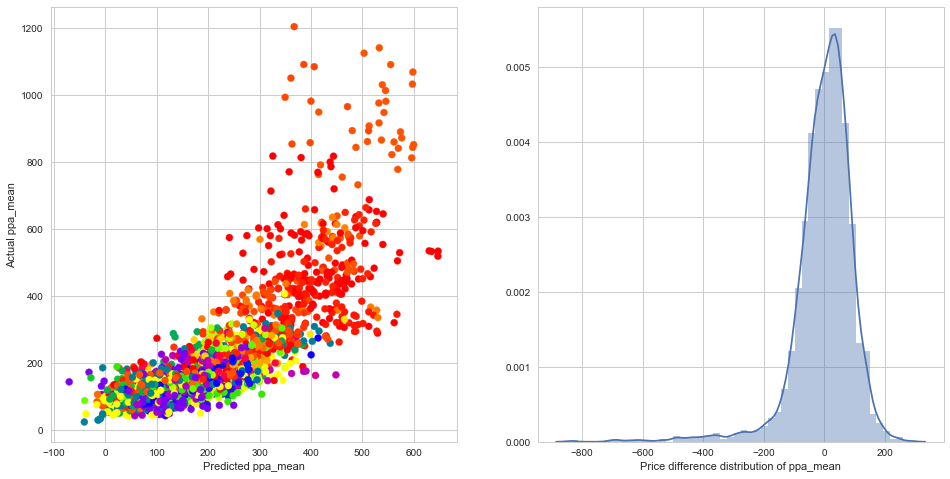

In [38]:
# we try a regression analysis on mean prices
df_custom = Custom_df(df, target, do_pca, do_f_reg)
print(df_custom.result.summary())
plot_results(df_custom, target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:             ppa_median   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     340.7
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:24:44   Log-Likelihood:                -13595.
No. Observations:                2274   AIC:                         2.721e+04
Df Residuals:                    2262   BIC:                         2.728e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             205.9041      2.009    1

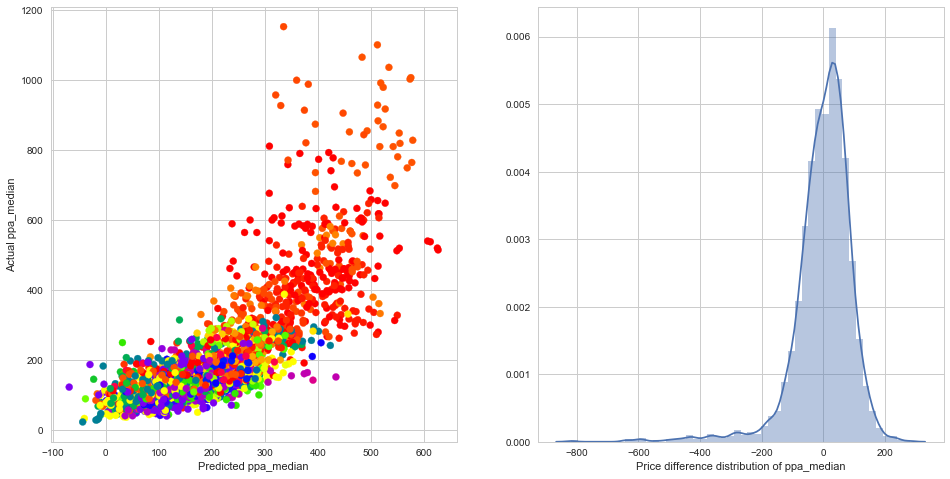

In [39]:
# we try a different approach and do the same on median prices
target = 'ppa_median'
df_custom = Custom_df(df, target, do_pca, do_f_reg)
print(df_custom.result.summary())
plot_results(df_custom, target)